# **SENTIMENT ANALYSIS**

### **IMPORT THE LIBRARIES**

In [ ]:
# import the basic libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import math
from sklearn import datasets

# import the Natural Language toolkit for preprocessing
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# import various methods and stopwords for text processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# BOW feature extraction
from sklearn.feature_extraction.text import CountVectorizer

# TF-IDF feature extraction
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# to scale the data
from sklearn.preprocessing import StandardScaler

# Set the seed
import random
random.seed(123)

# split the dataset
from sklearn.model_selection import train_test_split

# 1. Information Gain
# 2. Gini Index
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# 3. Naive Bayes
from sklearn.naive_bayes import GaussianNB

# 4. KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# 5. Random Forest
from sklearn.ensemble import RandomForestClassifier

# 6. Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier

# for summary report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# ignore warning message
import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **IMPORT THE DATASET**

In [ ]:
# Get the link for Dataset
#
DsLink = "https://raw.githubusercontent.com/Dataminimgproject/dataminingassignment/main/smileannotationsfinal%20(1).csv"

In [ ]:
# Fields that are present in the dataset
#
fields = ["Key", "Tweet", "Emotion"]

In [ ]:
# Import the dataset 
#
tweetdata = pd.read_csv(DsLink, names=fields)

In [ ]:
# Print the top 5 tuples of the dataset using the head() command
#
tweetdata.head()

,Key,Tweet,Emotion
0,611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
1,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
2,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
3,614877582664835073,@Sofabsports thank you for following me back. ...,happy
4,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [ ]:
# Print the dimensions of the dataset
#
tweetdata.shape

(3085, 3)

In the dataset, with each tweet there is certain emotion attribute attached along. This is the target variable whereas the tweet attribute is the independent variable for classification.

### **DATASET VISUALISATION AND ANALYSIS**

In [ ]:
# Analyse and define the dataset
# Key for all the tweets generated (Not relevant so deprecated)
#
# Remove the Key field
tweetdata=tweetdata.iloc[:,1:3]
tweetdata.head()

,Tweet,Emotion
0,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
1,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
2,@SelectShowcase @Tate_StIves ... Replace with ...,happy
3,@Sofabsports thank you for following me back. ...,happy
4,@britishmuseum @TudorHistory What a beautiful ...,happy


In [ ]:
# Count the values under the Emotion Attribute
#
tweetdata['Emotion'].value_counts()

nocode               1572
happy                1137
not-relevant          214
angry                  57
surprise               35
sad                    32
happy|surprise         11
happy|sad               9
disgust|angry           7
disgust                 6
sad|disgust             2
sad|angry               2
sad|disgust|angry       1
Name: Emotion, dtype: int64

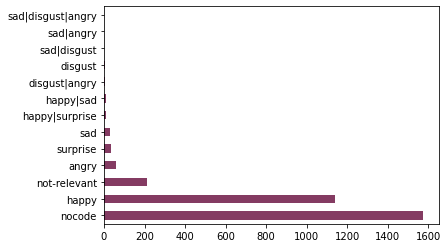

In [ ]:
# Above obtained count values can be better visualised as:
#
tweetdata['Emotion'].value_counts().plot(kind='barh',color="#843b62")

In [ ]:
# From the graph above, we can see that two values do not hold importance for Sentiment Analysis.
# 1-> nocode
# 2-> not-relevant
# Hence, we remove the tuples containing "nocode" and "not-relevant" values for Emotion Attribute.
#
tweetdata.drop(tweetdata[tweetdata['Emotion'] == 'nocode'].index, inplace = True)
tweetdata.drop(tweetdata[tweetdata['Emotion'] == 'not-relevant'].index, inplace = True)
#
# Next we convert the fields with more than one Emotion value to the first value (as instructed)
#
tweetdata = tweetdata.replace('sad|disgust','sad')
tweetdata = tweetdata.replace('happy|surprise','happy')
tweetdata = tweetdata.replace('happy|sad','happy')
tweetdata = tweetdata.replace('sad|angry','sad')
tweetdata = tweetdata.replace('disgust|angry','disgust')
tweetdata = tweetdata.replace('sad|disgust','sad')
tweetdata = tweetdata.replace('sad|disgust|angry','sad')

In [ ]:
tweetdata.head()

,Tweet,Emotion
1,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
2,@SelectShowcase @Tate_StIves ... Replace with ...,happy
3,@Sofabsports thank you for following me back. ...,happy
4,@britishmuseum @TudorHistory What a beautiful ...,happy
5,@NationalGallery @ThePoldarkian I have always ...,happy


In [ ]:
# Recheck the values for Emotion
#
tweetdata['Emotion'].value_counts()

happy       1157
angry         57
sad           37
surprise      35
disgust       13
Name: Emotion, dtype: int64

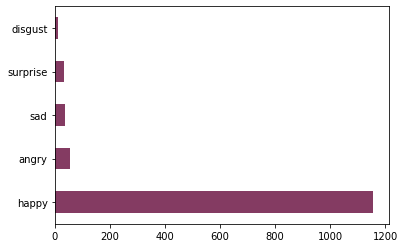

In [ ]:
# Plot the graph to visualise the new distribution of values
#
tweetdata['Emotion'].value_counts().plot(kind='barh',color="#843b62")

 ### **PREPROCESSING THE TWEET DATA**


The tweet data contains unstructured data with layman's language which needs to be converted to structured form for analysis. We can do that by converting text into numerical form and represent the occurance of each word in the form of a matrix. But before doing that, we need to remove the stopwords which are not of much relevance in the data.

In [ ]:
# Filter the texts from tweet attribute based on defined rules
#
# Create set of stopwords
stop_words = set(stopwords.words('english'))

# Define a function to preprocess the tweet texts
def preprocess_tweet_text(Tweet):

  # conversion to lowercase
  Tweet = Tweet.lower()

  # remove URL
  Tweet = re.sub(r'\d+', '', Tweet)
  Tweet = re.sub(r"http\S+|https\S+", " ", Tweet, flags = re.MULTILINE)

  # remove punctuation
  Tweet = Tweet.translate(str.maketrans(" ", " ", string.punctuation))

  # remove user @ reference and #  
  Tweet = re.sub('\@\w|\#', " ", Tweet)

  # remove stopwords and words with length less than equal to 2
  tweet_tokens = word_tokenize(Tweet)
  filtered_words = [word for word in tweet_tokens if word not in stop_words and len(word) > 2]

  # stemming
  # ps = PortStemmer()
  # stemmed_words = [ps.stem(w) for w in filtered_words]

  # lemmatizing
  lemmatizer = WordNetLemmatizer()
  lemma_words = [lemmatizer.lemmatize(w, pos = 'a') for w in filtered_words]

  return " ".join(lemma_words)

In [ ]:
# Function call for preprocessing
#
tweetdata["Tweet"] = tweetdata.Tweet.apply(preprocess_tweet_text)
tweetdata.head()

,Tweet,Emotion
1,dorian gray rainbow scarf lovewins britishmuseum,happy
2,selectshowcase tatestives replace wish artist ...,happy
3,sofabsports thank following back great hear di...,happy
4,britishmuseum tudorhistory beautiful jewel por...,happy
5,nationalgallery thepoldarkian always loved pai...,happy


In [ ]:
# list the preprocesssed tweets in documents
documents = [tweetdata.Tweet]
documents

[1        dorian gray rainbow scarf lovewins britishmuseum
 2       selectshowcase tatestives replace wish artist ...
 3       sofabsports thank following back great hear di...
 4       britishmuseum tudorhistory beautiful jewel por...
 5       nationalgallery thepoldarkian always loved pai...
                               ...                        
 3076    good see liveatlicas art collection leedsartga...
 3077     rammuseum thanks well look next week friday done
 3079    britishmuseum thanks ranking tripadvisor thing...
 3080    alihaggett looking forward public engagement e...
 3082                mrstuchbery britishmuseum mesmerising
 Name: Tweet, Length: 1299, dtype: object]

### **FEATURE EXTRACTION WITH BOW AND TF-IDF**

In [ ]:
# Create a list of words for each document (tuple)
#
col_tweet_list = tweetdata['Tweet'].tolist()
col_tweet_list[0]

'dorian gray rainbow scarf lovewins britishmuseum'

#### Using BOW Feature Extraction


In [ ]:
# Extract the features by BOW method
# Use the CountVectorizer to get of count of each word
#
#count_vect = CountVectorizer(ngram_range=(1,2) ) 
count_vect = CountVectorizer() 
final_bow_count = count_vect.fit_transform(col_tweet_list)

# Scaling
final_bow_np = StandardScaler(with_mean=False).fit_transform(final_bow_count )
final_bow_np

<1299x3926 sparse matrix of type '<class 'numpy.float64'>'
	with 11173 stored elements in Compressed Sparse Row format>

#### Using TFIDF Feature Extraction


In [ ]:
# Extract the features by TFIDF method
# Use the TfidfVectorizer to generate the processed features
#
tf_idf_vec = TfidfVectorizer()#ngram_range=(2,2))
final_tfidf_count = tf_idf_vec.fit_transform(col_tweet_list)

# Scaling
final_tfidf_np = StandardScaler(with_mean=False).fit_transform(final_tfidf_count)
final_tfidf_np

<1299x3926 sparse matrix of type '<class 'numpy.float64'>'
	with 11173 stored elements in Compressed Sparse Row format>

### **SPLIT THE DATA**

For the sake of simplicity, 'X' and 'Y' have been taken as the variable names for independent and dependent attributes respectively, in BOW method while 'x' and 'y' in TFIDF method for same purpose.

#### For Features Extracted using BOW

In [ ]:
X = final_bow_np
Y = tweetdata['Emotion']

# Split the data into train and test data
#
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

In [ ]:
X_train.shape

(909, 3926)

In [ ]:
Y_train.shape

(909,)

In [ ]:
X_test.shape

(390, 3926)

In [ ]:
Y_test.shape

(390,)

#### For Features Extracted using TFIDF

In [ ]:
x = final_tfidf_np
y = tweetdata['Emotion']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [ ]:
x_train.shape

(909, 3926)

In [ ]:
y_train.shape

(909,)

In [ ]:
x_test.shape

(390, 3926)

In [ ]:
y_test.shape

(390,)

## **CLASSIFIER 1 : INFORMATION GAIN**

### **TRAINING THE MODEL w.r.t. BOW**

In [ ]:
IGClassifier=DecisionTreeClassifier(criterion='entropy',max_depth=5)
IGClassifier.fit(X_train,Y_train)
IGClassifier

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### **TESTING THE MODEL w.r.t. BOW**

In [ ]:
Y_predIG=IGClassifier.predict(X_test)
#predictions
len(Y_predIG)

390

In [ ]:
predIG = pd.DataFrame({'Actual' : Y_test.values.ravel(), 'Predicted' : Y_predIG})
predIG.head()

,Actual,Predicted
0,happy,happy
1,happy,happy
2,happy,happy
3,happy,happy
4,happy,happy


### **ANALYSIS OF TEST RESULTS**

In [ ]:
# count the number of mismatches
count = 0
for i in range(0, len(predIG)):
    if Y_predIG[i] != Y_test.values.ravel()[i]:
        count = count + 1
print("Count of Wrong Prediction : " ,count)

Count of Wrong Prediction :  46


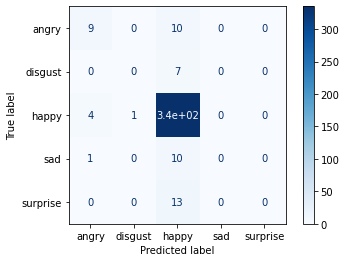

In [ ]:
# Confusion Matrix
plot_confusion_matrix(IGClassifier, X_test, Y_test, cmap=plt.cm.Blues)

In [ ]:
# Accuracy
print("Accuracy : ", round(100 * accuracy_score(Y_test, Y_predIG), 3))
#
# Precision
print("Precision : ", round(100 * precision_score(Y_test, Y_predIG, average='weighted'), 3))
#
# Recall
print("Recall : ", round(100 * recall_score(Y_test, Y_predIG, average='weighted'), 3))
#
#F1 Score
print("F1 Score : ", round(100 * f1_score(Y_test, Y_predIG, average='weighted'), 3))

Accuracy :  88.205
Precision :  81.012
Recall :  88.205
F1 Score :  84.35


In [ ]:
# Summary
print(classification_report(Y_test, Y_predIG))

              precision    recall  f1-score   support

       angry       0.64      0.47      0.55        19
     disgust       0.00      0.00      0.00         7
       happy       0.89      0.99      0.94       340
         sad       0.00      0.00      0.00        11
    surprise       0.00      0.00      0.00        13

    accuracy                           0.88       390
   macro avg       0.31      0.29      0.30       390
weighted avg       0.81      0.88      0.84       390



### **TRAINING THE MODEL w.r.t. TFIDF**

In [ ]:
IGClassifier2=DecisionTreeClassifier(criterion='entropy',max_depth=5)
IGClassifier2.fit(x_train,y_train)
IGClassifier2

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### **TESTING THE MODEL w.r.t. TFIDF**

In [ ]:
y_predIG2=IGClassifier.predict(x_test)
#predictions
len(y_predIG2)

390

In [ ]:
predIG2 = pd.DataFrame({'Actual' : y_test.values.ravel(), 'Predicted' : y_predIG2})
predIG2.head()

,Actual,Predicted
0,happy,happy
1,surprise,happy
2,happy,happy
3,happy,happy
4,happy,happy


### **ANALYSIS OF TEST RESULTS**

In [ ]:
# count the number of mismatches
count = 0
for i in range(0, len(predIG2)):
    if y_predIG2[i] != y_test.values.ravel()[i]:
        count = count + 1
print("Count of Wrong Prediction : " ,count)

Count of Wrong Prediction :  32


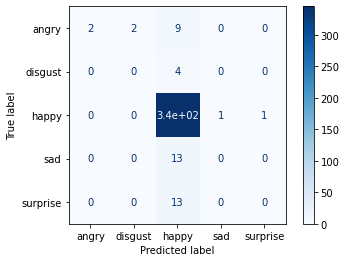

In [ ]:
# Confusion Matrix
plot_confusion_matrix(IGClassifier2, x_test.todense(), y_test, cmap=plt.cm.Blues)

In [ ]:
# Accuracy
print("Accuracy : ", round(100 * accuracy_score(y_test, y_predIG2), 3))
#
# Precision
print("Precision : ", round(100 * precision_score(y_test, y_predIG2, average='weighted'), 3))
#
# Recall
print("Recall : ", round(100 * recall_score(y_test, y_predIG2, average='weighted'), 3))
#
#F1 Score
print("F1 Score : ", round(100 * f1_score(y_test, y_predIG2, average='weighted'), 3))

Accuracy :  91.795
Precision :  91.658
Recall :  91.795
F1 Score :  88.893


In [ ]:
# Summary
print(classification_report(y_test, y_predIG2))

              precision    recall  f1-score   support

       angry       1.00      0.77      0.87        13
     disgust       0.00      0.00      0.00         4
       happy       0.92      1.00      0.96       347
         sad       1.00      0.08      0.14        13
    surprise       1.00      0.08      0.14        13

    accuracy                           0.92       390
   macro avg       0.78      0.38      0.42       390
weighted avg       0.92      0.92      0.89       390



## **CLASSIFIER 2 : GINI INDEX**

### **TRAINING THE MODEL w.r.t. BOW**

In [ ]:
GIClassifier=DecisionTreeClassifier(criterion='gini',max_depth=5)

In [ ]:
GIClassifier.fit(X_train,Y_train)
GIClassifier

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### **TESTING THE MODEL w.r.t. BOW**

In [ ]:
Y_predGI=GIClassifier.predict(X_test)
#predictions
len(Y_predGI)

390

In [ ]:
predGI = pd.DataFrame({'Actual' : Y_test.values.ravel(), 'Predicted' : Y_predGI})
predGI.head()

,Actual,Predicted
0,happy,happy
1,happy,happy
2,happy,happy
3,happy,happy
4,happy,happy


### **ANALYSIS OF TEST RESULTS**

In [ ]:
# count the number of mismatches
count = 0
for i in range(0, len(predGI)):
    if Y_predGI[i] != Y_test.values.ravel()[i]:
        count = count + 1
print("Count of Wrong Prediction : " ,count)

Count of Wrong Prediction :  44


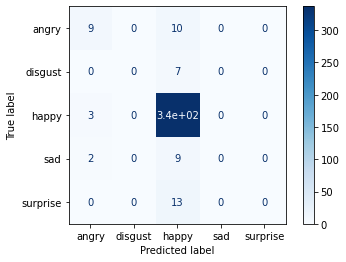

In [ ]:
# Confusion Matrix
plot_confusion_matrix(GIClassifier, X_test, Y_test, cmap=plt.cm.Blues)

In [ ]:
# Accuracy
print("Accuracy : ", round(100 * accuracy_score(Y_test, Y_predGI), 3))
#
# Precision
print("Precision : ", round(100 * precision_score(Y_test, Y_predGI, average='weighted'), 3))
#
# Recall
print("Recall : ", round(100 * recall_score(Y_test, Y_predGI, average='weighted'), 3))
#
#F1 Score
print("F1 Score : ", round(100 * f1_score(Y_test, Y_predGI, average='weighted'), 3))

Accuracy :  88.718
Precision :  81.269
Recall :  88.718
F1 Score :  84.723


In [ ]:
# Summary
print(classification_report(Y_test, Y_predGI))

              precision    recall  f1-score   support

       angry       0.64      0.47      0.55        19
     disgust       0.00      0.00      0.00         7
       happy       0.90      0.99      0.94       340
         sad       0.00      0.00      0.00        11
    surprise       0.00      0.00      0.00        13

    accuracy                           0.89       390
   macro avg       0.31      0.29      0.30       390
weighted avg       0.81      0.89      0.85       390



### **TRAINING THE MODEL w.r.t. TFIDF**

In [ ]:
GIClassifier2 = DecisionTreeClassifier(criterion='gini',max_depth=5)

In [ ]:
GIClassifier2.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### **TESTING THE MODEL w.r.t. TFIDF**

In [ ]:
y_predGI2=GIClassifier.predict(x_test)
#predictions
len(y_predGI2)

390

In [ ]:
predGI2 = pd.DataFrame({'Actual' : y_test.values.ravel(), 'Predicted' : y_predGI2})
predGI2.head()

,Actual,Predicted
0,happy,happy
1,surprise,happy
2,happy,happy
3,happy,happy
4,happy,happy


### **ANALYSIS OF TEST RESULTS**

In [ ]:
# count the number of mismatches
count = 0
for i in range(0, len(predGI2)):
    if y_predGI2[i] != y_test.values.ravel()[i]:
        count = count + 1
print("Count of Wrong Prediction : " ,count)

Count of Wrong Prediction :  33


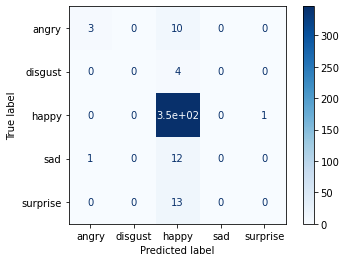

In [ ]:
# Confusion Matrix
plot_confusion_matrix(GIClassifier2, x_test.todense(), y_test, cmap=plt.cm.Blues)

In [ ]:
# Accuracy
print("Accuracy : ", round(100 * accuracy_score(y_test, y_predGI2), 3))
#
# Precision
print("Precision : ", round(100 * precision_score(y_test, y_predGI2, average='weighted'), 3))
#
# Recall
print("Recall : ", round(100 * recall_score(y_test, y_predGI2, average='weighted'), 3))
#
#F1 Score
print("F1 Score : ", round(100 * f1_score(y_test, y_predGI2, average='weighted'), 3))

Accuracy :  91.538
Precision :  84.492
Recall :  91.538
F1 Score :  87.83


In [ ]:
# Summary
print(classification_report(y_test, y_predGI2))

              precision    recall  f1-score   support

       angry       0.91      0.77      0.83        13
     disgust       0.00      0.00      0.00         4
       happy       0.92      1.00      0.96       347
         sad       0.00      0.00      0.00        13
    surprise       0.00      0.00      0.00        13

    accuracy                           0.92       390
   macro avg       0.36      0.35      0.36       390
weighted avg       0.84      0.92      0.88       390



## **CLASSIFIER 3 : NAIVE BAYES**

### **TRAINING THE MODEL w.r.t. BOW**

In [ ]:
NBClassifier = GaussianNB()
NBClassifier.fit(X_train.todense(),Y_train)
NBClassifier

GaussianNB(priors=None, var_smoothing=1e-09)

### **TESTING THE MODEL w.r.t. BOW**

In [ ]:
Y_predNB = NBClassifier.predict(X_test.todense()) # store the prediction data
#y_pred
len(Y_predNB)

390

In [ ]:
predNB = pd.DataFrame({'Actual' : Y_test, 'Predicted' : Y_predNB})
predNB.head()

,Actual,Predicted
1417,happy,happy
606,happy,happy
1642,happy,disgust
153,happy,happy
2429,happy,happy


#### **ANALYSIS OF TEST RESULTS**

In [ ]:
# count the number of mismatches
count = 0
for i in range(0, len(predNB)):
    if Y_predNB[i] != Y_test.values.ravel()[i]:
        count = count + 1
print("Count of Wrong Prediction : " ,count)

Count of Wrong Prediction :  77


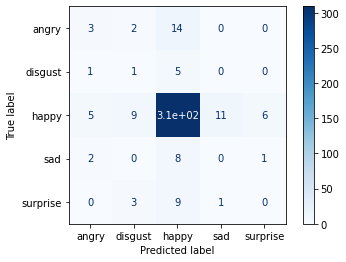

In [ ]:
# Confusion Matrix
plot_confusion_matrix(NBClassifier, X_test.todense(), Y_test, cmap=plt.cm.Blues)

In [ ]:
# Accuracy
print("Accuracy : ", round(100 * accuracy_score(Y_test, Y_predNB), 3))
#
# Precision
print("Precision : ", round(100 * precision_score(Y_test, Y_predNB, average='weighted'), 3))
#
# Recall
print("Recall : ", round(100 * recall_score(Y_test, Y_predNB, average='weighted'), 3))
#
#F1 Score
print("F1 Score : ", round(100 * f1_score(Y_test, Y_predNB, average='weighted'), 3))

Accuracy :  80.256
Precision :  79.531
Recall :  80.256
F1 Score :  79.79


In [ ]:
# Summary
print(classification_report(Y_test, Y_predNB))

              precision    recall  f1-score   support

       angry       0.27      0.16      0.20        19
     disgust       0.07      0.14      0.09         7
       happy       0.90      0.91      0.90       340
         sad       0.00      0.00      0.00        11
    surprise       0.00      0.00      0.00        13

    accuracy                           0.80       390
   macro avg       0.25      0.24      0.24       390
weighted avg       0.80      0.80      0.80       390



### **TRAINING THE MODEL w.r.t. TFIDF**

In [ ]:
NBClassifier2 = GaussianNB()
NBClassifier2.fit(x_train.todense(),y_train)
NBClassifier2

GaussianNB(priors=None, var_smoothing=1e-09)

### **TESTING THE MODEL w.r.t. TFIDF**

In [ ]:
y_predNB2 = NBClassifier.predict(x_test.todense()) # store the prediction data
#y_predNB2
len(y_predNB2)

390

In [ ]:
predNB2 = pd.DataFrame({'Actual' : y_test, 'Predicted' : y_predNB2})
predNB2.head()

,Actual,Predicted
1165,happy,happy
1536,surprise,happy
991,happy,happy
1292,happy,happy
211,happy,happy


#### **ANALYSIS OF TEST RESULTS**

In [ ]:
# count the number of mismatches
count = 0
for i in range(0, len(predNB2)):
    if y_predNB2[i] != y_test.values.ravel()[i]:
        count = count + 1
print("Count of Wrong Prediction : " ,count)

Count of Wrong Prediction :  21


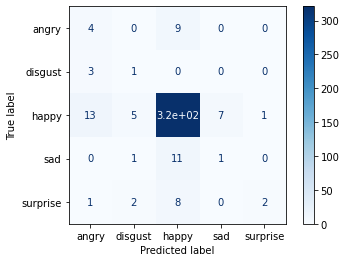

In [ ]:
# Confusion Matrix
plot_confusion_matrix(NBClassifier2, x_test.todense(), y_test, cmap=plt.cm.Blues)

In [ ]:
# Accuracy
print("Accuracy : ", round(100 * accuracy_score(y_test, y_predNB2), 3))
#
# Precision
print("Precision : ", round(100 * precision_score(y_test, y_predNB2, average='weighted'), 3))
#
# Recall
print("Recall : ", round(100 * recall_score(y_test, y_predNB2, average='weighted'), 3))
#
#F1 Score
print("F1 Score : ", round(100 * f1_score(y_test, y_predNB2, average='weighted'), 3))

Accuracy :  94.615
Precision :  95.493
Recall :  94.615
F1 Score :  94.843


In [ ]:
# Summary
print(classification_report(y_test, y_predNB2))

              precision    recall  f1-score   support

       angry       0.69      0.85      0.76        13
     disgust       0.33      0.75      0.46         4
       happy       0.98      0.97      0.98       347
         sad       0.82      0.69      0.75        13
    surprise       0.89      0.62      0.73        13

    accuracy                           0.95       390
   macro avg       0.74      0.78      0.73       390
weighted avg       0.95      0.95      0.95       390



## **CLASSIFIER 4 : KNN (K-NEAREST NEIGHBOUR)**

In [ ]:

def find_optimal_k(Xtrain,Ytrain, myList):
   
    #creating odd list of K for KNN
    #myList = list(range(0,40))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, Xtrain, Ytrain, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)


    plt.figure(figsize=(10,6))
    plt.plot(list(filter(lambda x: x % 2 != 0, myList)),MSE,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Error Rate vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    
    return optimal_k

### **TRAINING THE MODEL w.r.t. BOW**





The optimal number of neighbors is 1.
the misclassification error for each k value is :  [0.093 0.1   0.101 0.101 0.101 0.101 0.101 0.101 0.101 0.101 0.101 0.101
 0.101 0.101 0.101 0.101 0.101 0.101 0.101 0.101 0.101 0.101 0.101 0.101
 0.101]


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

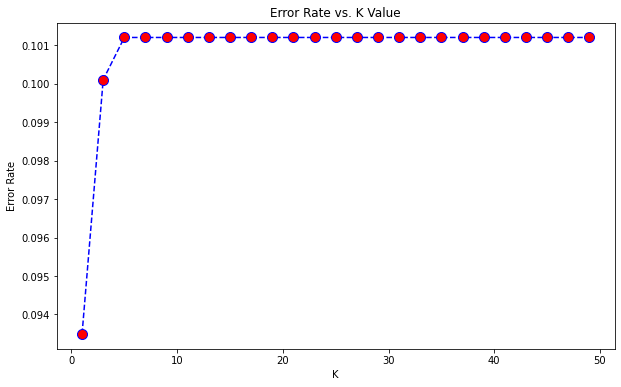

In [ ]:
myList = list(range(0,50))
optimal_k = find_optimal_k(X_train ,Y_train,myList)
KNNClassifier = KNeighborsClassifier(n_neighbors = optimal_k)
KNNClassifier.fit(X_train, Y_train)
KNNClassifier

### **TESTING THE MODEL w.r.t. BOW**

In [ ]:
Y_predKNN = KNNClassifier.predict(X_test.todense()) # store the prediction data
#Y_predKNN
len(Y_predKNN)

390

In [ ]:
predKNN = pd.DataFrame({'Actual' : Y_test, 'Predicted' : Y_predKNN})
predKNN.head()

,Actual,Predicted
1417,happy,happy
606,happy,happy
1642,happy,happy
153,happy,happy
2429,happy,happy


#### **ANALYSIS OF TEST RESULTS**

In [ ]:
# count the number of mismatches
count = 0
for i in range(0, len(predKNN)):
    if Y_predKNN[i] != Y_test.values.ravel()[i]:
        count = count + 1
print("Count of Wrong Prediction : " ,count)

Count of Wrong Prediction :  48


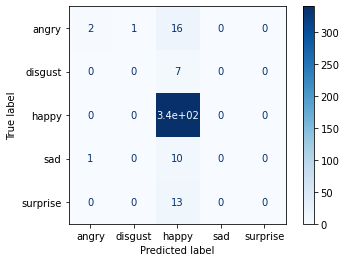

In [ ]:
# Confusion Matrix
plot_confusion_matrix(KNNClassifier, X_test.todense(), Y_test, cmap=plt.cm.Blues)

In [ ]:
# Accuracy
print("Accuracy : ", round(100 * accuracy_score(Y_test, Y_predKNN), 3))
#
# Precision
print("Precision : ", round(100 * precision_score(Y_test, Y_predKNN, average='weighted'), 3))
#
# Recall
print("Recall : ", round(100 * recall_score(Y_test, Y_predKNN, average='weighted'), 3))
#
#F1 Score
print("F1 Score : ", round(100 * f1_score(Y_test, Y_predKNN, average='weighted'), 3))

Accuracy :  87.692
Precision :  80.038
Recall :  87.692
F1 Score :  82.541


In [ ]:
# Summary
print(classification_report(Y_test, Y_predKNN))

              precision    recall  f1-score   support

       angry       0.67      0.11      0.18        19
     disgust       0.00      0.00      0.00         7
       happy       0.88      1.00      0.94       340
         sad       0.00      0.00      0.00        11
    surprise       0.00      0.00      0.00        13

    accuracy                           0.88       390
   macro avg       0.31      0.22      0.22       390
weighted avg       0.80      0.88      0.83       390



### **TRAINING THE MODEL w.r.t. TFIDF**


The optimal number of neighbors is 1.
the misclassification error for each k value is :  [0.101 0.102 0.106 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109
 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109 0.109
 0.109]


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

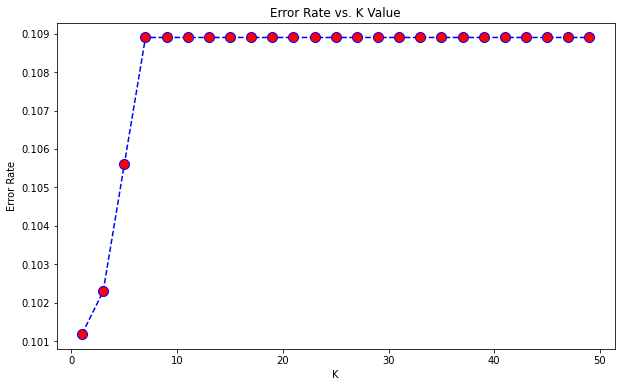

In [ ]:
myList = list(range(0,50))
optimal_k = find_optimal_k(x_train ,y_train,myList)
KNNClassifier2 = KNeighborsClassifier(n_neighbors = optimal_k)
KNNClassifier2.fit(x_train, y_train)
KNNClassifier2

### **TESTING THE MODEL w.r.t. TFIDF**

In [ ]:
y_predKNN = KNNClassifier2.predict(x_test.todense()) # store the prediction data
#y_predKNN
len(y_predKNN)

390

In [ ]:
predKNN = pd.DataFrame({'Actual' : y_test, 'Predicted' : y_predKNN})
predKNN.head()

,Actual,Predicted
1165,happy,happy
1536,surprise,happy
991,happy,happy
1292,happy,happy
211,happy,happy


#### **ANALYSIS OF TEST RESULTS**

In [ ]:
# count the number of mismatches
count = 0
for i in range(0, len(predKNN)):
    if y_predKNN[i] != y_test.values.ravel()[i]:
        count = count + 1
print("Count of Wrong Prediction : " ,count)

Count of Wrong Prediction :  42


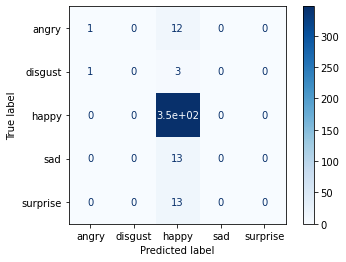

In [ ]:
# Confusion Matrix
plot_confusion_matrix(KNNClassifier2, x_test.todense(), y_test, cmap=plt.cm.Blues)

In [ ]:
# Accuracy
print("Accuracy : ", round(100 * accuracy_score(y_test, y_predKNN), 3))
#
# Precision
print("Precision : ", round(100 * precision_score(y_test, y_predKNN, average='weighted'), 3))
#
# Recall
print("Recall : ", round(100 * recall_score(y_test, y_predKNN, average='weighted'), 3))
#
#F1 Score
print("F1 Score : ", round(100 * f1_score(y_test, y_predKNN, average='weighted'), 3))

Accuracy :  89.231
Precision :  81.239
Recall :  89.231
F1 Score :  84.456


In [ ]:
# Summary
print(classification_report(y_test, y_predKNN))

              precision    recall  f1-score   support

       angry       0.50      0.08      0.13        13
     disgust       0.00      0.00      0.00         4
       happy       0.89      1.00      0.94       347
         sad       0.00      0.00      0.00        13
    surprise       0.00      0.00      0.00        13

    accuracy                           0.89       390
   macro avg       0.28      0.22      0.22       390
weighted avg       0.81      0.89      0.84       390



## **CLASSIFIER 5 : RANDOM FOREST**

### **TRAINING THE MODEL w.r.t. BOW**

In [ ]:
# Model Creation
#
RFClassifier = RandomForestClassifier(n_estimators = 3, random_state = 0)
RFClassifier.fit(X_train, Y_train)
RFClassifier

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### **TESTING THE MODEL w.r.t. BOW**

In [ ]:
Y_predRF = RFClassifier.predict(X_test)

In [ ]:
predRF = pd.DataFrame({'Actual' : Y_test.values.ravel(), 'Predicted' : Y_predRF})
predRF.head()

,Actual,Predicted
0,happy,happy
1,happy,happy
2,happy,happy
3,happy,happy
4,happy,happy


### **ANALYSIS OF TEST RESULTS**

In [ ]:
# count the number of mismatches
count = 0
for i in range(0, len(predRF)):
    if Y_predRF[i] != Y_test.values.ravel()[i]:
        count = count + 1
print("Count of Wrong Prediction : " ,count)

Count of Wrong Prediction :  50


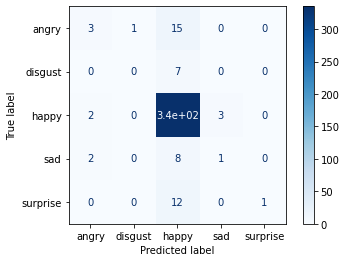

In [ ]:
# Confusion Matrix
plot_confusion_matrix(RFClassifier, X_test, Y_test, cmap=plt.cm.Blues)

In [ ]:
# Accuracy
print("Accuracy : ", round(100 * accuracy_score(Y_test, Y_predRF), 3))
#
# Precision
print("Precision : ", round(100 * precision_score(Y_test, Y_predRF, average='weighted'), 3))
#
# Recall
print("Recall : ", round(100 * recall_score(Y_test, Y_predRF, average='weighted'), 3))
#
#F1 Score
print("F1 Score : ", round(100 * f1_score(Y_test, Y_predRF, average='weighted'), 3))

Accuracy :  87.179
Precision :  83.594
Recall :  87.179
F1 Score :  83.441


In [ ]:
# Summary
print(classification_report(Y_test, Y_predRF))

              precision    recall  f1-score   support

       angry       0.43      0.16      0.23        19
     disgust       0.00      0.00      0.00         7
       happy       0.89      0.99      0.93       340
         sad       0.25      0.09      0.13        11
    surprise       1.00      0.08      0.14        13

    accuracy                           0.87       390
   macro avg       0.51      0.26      0.29       390
weighted avg       0.84      0.87      0.83       390



### **TRAINING THE MODEL w.r.t. TFIDF**

In [ ]:
# Model Creation
#
RFClassifier2 = RandomForestClassifier(n_estimators = 3, random_state = 0)
RFClassifier2.fit(x_train, y_train)
RFClassifier2

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### **TESTING THE MODEL w.r.t. TFIDF**

In [ ]:
y_predRF = RFClassifier2.predict(x_test)

In [ ]:
predRF = pd.DataFrame({'Actual' : y_test.values.ravel(), 'Predicted' : y_predRF})
predRF.head()

,Actual,Predicted
0,happy,happy
1,surprise,happy
2,happy,happy
3,happy,happy
4,happy,happy


### **ANALYSIS OF TEST RESULTS**

In [ ]:
# count the number of mismatches
count = 0
for i in range(0, len(predRF)):
    if y_predRF[i] != y_test.values.ravel()[i]:
        count = count + 1
print("Count of Wrong Prediction : " ,count)

Count of Wrong Prediction :  46


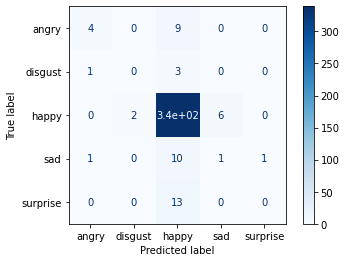

In [ ]:
# Confusion Matrix
plot_confusion_matrix(RFClassifier2, x_test, y_test, cmap=plt.cm.Blues)

In [ ]:
# Accuracy
print("Accuracy : ", round(100 * accuracy_score(y_test, y_predRF), 3))
#
# Precision
print("Precision : ", round(100 * precision_score(y_test, y_predRF, average='weighted'), 3))
#
# Recall
print("Recall : ", round(100 * recall_score(y_test, y_predRF, average='weighted'), 3))
#
#F1 Score
print("F1 Score : ", round(100 * f1_score(y_test, y_predRF, average='weighted'), 3))

Accuracy :  88.205
Precision :  83.346
Recall :  88.205
F1 Score :  85.405


In [ ]:
# Summary
print(classification_report(y_test, y_predRF))

              precision    recall  f1-score   support

       angry       0.67      0.31      0.42        13
     disgust       0.00      0.00      0.00         4
       happy       0.91      0.98      0.94       347
         sad       0.14      0.08      0.10        13
    surprise       0.00      0.00      0.00        13

    accuracy                           0.88       390
   macro avg       0.34      0.27      0.29       390
weighted avg       0.83      0.88      0.85       390



## **CLASSIFIER 6 : GRADIENT BOOST**

### **TRAINING THE MODEL w.r.t. BOW**

In [ ]:
GBClassifier = GradientBoostingClassifier(max_depth=2,
    n_estimators=3,
    learning_rate=1.0
)

In [ ]:
GBClassifier.fit(X_train, Y_train.values.ravel())
GBClassifier

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=3,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### **TESTING THE MODEL w.r.t. BOW**

In [ ]:
Y_predGB = GBClassifier.predict(X_test)
len(Y_predGB)

390

In [ ]:
predGB = pd.DataFrame({'Actual' : Y_test.values.ravel(), 'Predicted' : Y_predGB})
predGB.head()

,Actual,Predicted
0,happy,happy
1,happy,happy
2,happy,happy
3,happy,happy
4,happy,happy


### **ANALYSIS OF TEST RESULTS**

In [ ]:
# count the number of mismatches
count = 0
for i in range(0, len(predGB)):
    if Y_predGB[i] != Y_test.values.ravel()[i]:
        count = count + 1
print("Count of Wrong Prediction : " ,count)

Count of Wrong Prediction :  53


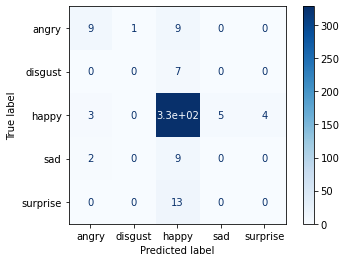

In [ ]:
# Confusion Matrix
plot_confusion_matrix(GBClassifier, X_test, Y_test, cmap=plt.cm.Blues)

In [ ]:
# Accuracy
print("Accuracy : ", round(100 * accuracy_score(Y_test, Y_predGB), 3))
#
# Precision
print("Precision : ", round(100 * precision_score(Y_test, Y_predGB, average='weighted'), 3))
#
# Recall
print("Recall : ", round(100 * recall_score(Y_test, Y_predGB, average='weighted'), 3))
#
#F1 Score
print("F1 Score : ", round(100 * f1_score(Y_test, Y_predGB, average='weighted'), 3))

Accuracy :  86.41
Precision :  81.26
Recall :  86.41
F1 Score :  83.663


In [ ]:
# Summary
print(classification_report(Y_test, Y_predGB))

              precision    recall  f1-score   support

       angry       0.64      0.47      0.55        19
     disgust       0.00      0.00      0.00         7
       happy       0.90      0.96      0.93       340
         sad       0.00      0.00      0.00        11
    surprise       0.00      0.00      0.00        13

    accuracy                           0.86       390
   macro avg       0.31      0.29      0.29       390
weighted avg       0.81      0.86      0.84       390



### **TRAINING THE MODEL w.r.t. TFIDF**

In [ ]:
GBClassifier2 = GradientBoostingClassifier(max_depth=2,
    n_estimators=3,
    learning_rate=1.0
)

In [ ]:
GBClassifier2.fit(x_train, y_train.values.ravel())
GBClassifier2

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=3,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

### **TESTING THE MODEL w.r.t. TFIDF**

In [ ]:
y_predGB2 = GBClassifier2.predict(x_test)
len(y_predGB2)

390

In [ ]:
predGB2 = pd.DataFrame({'Actual' : y_test.values.ravel(), 'Predicted' : y_predGB2})
predGB2.head()

,Actual,Predicted
0,happy,happy
1,surprise,happy
2,happy,happy
3,happy,happy
4,happy,happy


### **ANALYSIS OF TEST RESULTS**

In [ ]:
# count the number of mismatches
count = 0
for i in range(0, len(predGB2)):
    if y_predGB2[i] != y_test.values.ravel()[i]:
        count = count + 1
print("Count of Wrong Prediction : " ,count)

Count of Wrong Prediction :  43


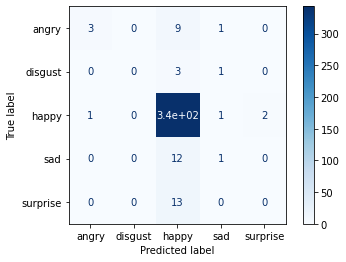

In [ ]:
# Confusion Matrix
plot_confusion_matrix(GBClassifier2, x_test, y_test, cmap=plt.cm.Blues)

In [ ]:
# Accuracy
print("Accuracy : ", round(100 * accuracy_score(y_test, y_predGB2), 3))
#
# Precision
print("Precision : ", round(100 * precision_score(y_test, y_predGB2, average='weighted'), 3))
#
# Recall
print("Recall : ", round(100 * recall_score(y_test, y_predGB2, average='weighted'), 3))
#
#F1 Score
print("F1 Score : ", round(100 * f1_score(y_test, y_predGB2, average='weighted'), 3))

Accuracy :  88.974
Precision :  83.644
Recall :  88.974
F1 Score :  85.525


In [ ]:
# Summary
print(classification_report(y_test, y_predGB2))

              precision    recall  f1-score   support

       angry       0.75      0.23      0.35        13
     disgust       0.00      0.00      0.00         4
       happy       0.90      0.99      0.94       347
         sad       0.25      0.08      0.12        13
    surprise       0.00      0.00      0.00        13

    accuracy                           0.89       390
   macro avg       0.38      0.26      0.28       390
weighted avg       0.84      0.89      0.86       390

